<center> 
    <h1> 
        Data Camp Project

 <center>
    <h1> 
        Prediction of the success rate of the French "brevet des collèges"

<div style="text-align: center">
<img src="img/diplome.png" width="300px">
</div>

<div style="text-align: right">
    <em>
        Authors : Cédric Allain - Alexis G. - Clotilde Miura - Artem Muliukov
    </em>
</div>
<div style="text-align: right">
    <em>
        with some edits from: Lucy Liu and Alex Gramfort at Paris-Saclay Center for Data Science.
    </em>
</div>

# Table of content
1. [Introduction](#Introduction)
    - [Social impact](#Social_impact)
    - [Performance indicators for public policy action](#Performance_indicator)
    - [Definition of the problem: Predict the success rate per *collège*](#Definition_problem)
2. [Data exploration](#Data_exploration)
    - [Target visualization](#Target_visualization)
    - [Naive merge with the city database](#Naive_merge)
    - [Geographic visualization](#Geographic_visualization)
    - [Macro socio-economic features](#Macro_socio_economic_features)
    - [Priority Education Network and "sensitive" schools](#Priority_education_network)
    - [Analysis of class size](#Class_size)
    - [Analysis of the quantitative features](#Quantitative_features)
    - [Correlation study](#Correlation_study)
3. [Workflow](#Workflow)
4. [Submission](#Submission)

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Introduction

Every year in France, just over 810,000 students in the fourth year of *collège* ("classe de troisième"), aged around 15, take the *brevet des collèges*, a diploma that completes the first cycle of secondary education. Since schooling is compulsory up to the age of 16 in France, all teenagers take the brevet exams, making it a universal measure of the level of French students of that age. In 2019, 86.5% of the 813,200 candidates obtained (passed) the national brevet diploma. Below is the evolution of the success rate in recent years:

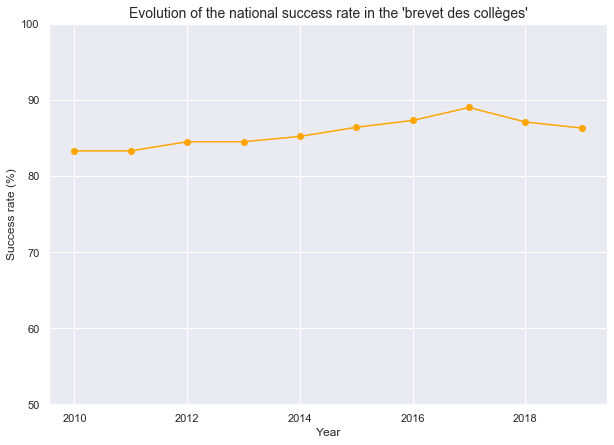

In [2]:
tx = pd.read_csv("data/college/tx_succes.csv", sep=";", decimal=',')
plt.figure(figsize=(10,7))
plt.plot(tx.annee, tx.taux, '-o', color='orange')
plt.xlabel("Year")
plt.ylabel("Success rate (%)")
plt.title("Evolution of the national success rate in the 'brevet des collèges'", fontsize=14)
plt.ylim(50,100)
plt.show()
# Source : https://www.data.gouv.fr/fr/datasets/le-diplome-national-du-brevet-00000000/#_

However, this rate is not the same for everyone. There are two streams in the examination, the general stream, in which 90% of the students are enrolled, and the vocational stream, so called "fillière professionnelle". For 2019, the pass rate is 87.8% in the general stream compared to 77.2% for the vocational stream. There is a similarly large gap between girls and boys, with a pass rate of 90% compared to 83% for boys.

Examination outcomes are more finely divided into:

* TB (Très bien) = 'Highest honors'
* B (Bien) = 'High honors'
* AB (Assez bien) = 'Honors'
* admis = 'Pass'
* echec = 'Fail'

The distribution of students obtaining each level is shown below:

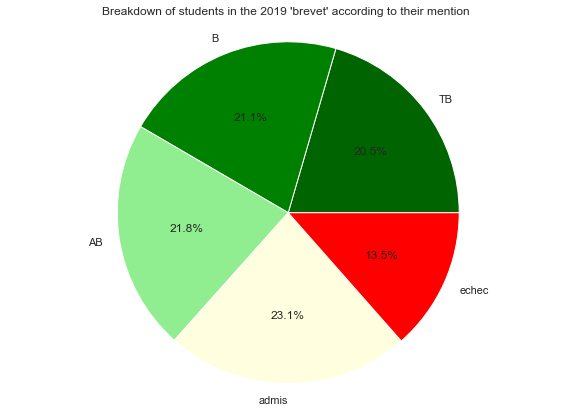

In [3]:
mentions = pd.read_csv("data/college/tx_mentions.csv", sep=";", decimal=',')
plt.figure(figsize=(10,7))
plt.pie(mentions.taux,
        labels=mentions.mention,
        colors=['darkgreen', 'green', 'lightgreen', 'lightyellow', 'red'],
        autopct='%1.1f%%')
plt.title("Breakdown of students in the 2019 'brevet' according to their mention")
plt.axis('equal')
plt.show()

## Social impact 

Education is a major issue and is a central element of the political policy of France. France spends more than 150 billion euros a year on education. Around 20% of this sum, 30 billion euros, is allocated to training at the first cycle of secondary education, in other words, at the *collège* level.

In 2017, the French national education system identified 7,200 public and private *collèges*. 79% of secondary school students were enrolled in a public school.

First of all, predicting the *brevet* pass rate per *collège* is important because it makes it possible to recognise spatial inequalities in the territory and to answer questions such as whether there is a divide between urban and rural *colleges*. Most importantly, predicting the success rate will make it possible to **identify** the factors related to the success of *classe de troisième* pupils in the *brevet des collèges* and, more generally. This will thus **enable** those in charge of education policy **to (re)allocate human and financial resources where these essential factors of success are weaker than elsewhere**, thus enabling the national education system to achieve its pedagogical objectives in secondary education. For example, small classes could be set up in the REP/REP+ zones (a kind of priority education network) in a targeted manner.

The aim of this challenge is to use the *brevet* success rate to identify factors associated with schools which have high success rates so that investment can be made in *collèges* without these factors.

The social impact of this system of allocating teaching and educational resources could help to **move closer to the republican principle of equal opportunities nationwide**.

### Performance indicators for public policy action

If this resource allocation program works well, we can expect to see the lowest-performing *collèges* catch up. In other words, *collèges* that are currently, or repeatedly year after year, below the national average should be expected to catch up with the national average.

To capture some of this "catch-up" effect, one can first look at the evolution of the variance of the distribution of patent success rates. Furthermore, it is also possible to look at the evolution between two dates of the mean for the group located below the national average with respect to the national average:
$$ \frac{\bar{y}^{1} - \bar{y}_{low}^{1}}{\bar{y}^{0} - \bar{y}_{low}^{0}}$$
where $\bar{y}^0$ is the national average success rate at time 0, and $\bar{y}_{low}^{0}$ is the average success rate among all schools that are in the first quartile of the distribution (the 25% of schools that have the lowest success rates), and similarly at time 1.

Thus, we expect this metric to be as small as possible, meaning that the below of the distribution is now more concentraded around the national average. On the contrary, a value close to 1 would mean that nothing has changed between the two dates, because even if the average of the last quartile would have increased, it is possible that this is only due to a general upward trend.

Another possible indicator would be to do the same thing but taking a specific group of *collèges*. For example, at date 0 we identify a group of *collèges* that are in difficulty (i.e., they have a very low success rate compared to other *collèges*), and it is within this group that we calculate the low average $\bar{y}_{low}^{0}$. At date 1, the low average $\bar{y}_{low}^{1}$ is calculated not on a new group of *collèges* but on the same as the previous data. Thus, the metric is more accurate in the sense that it can be used to track the specific evolution of a targeted group of *collèges*.

However, one must be aware that such a simplistic metric as this one does not make it possible to assess the effectiveness of a public policy as a whole, because on the one hand it takes only two dates, while on the other hand it is necessary to look over several years at the effects of a public policy. Moreover, in order to identify the real effects of a policy, it is necessary to evaluate a more advanced econometric model.

## Definition of the problem: Predict the success rate per *collège*

- Aim: Predict the success rate per *collège* in 2017.

- Scoring: "Root mean square error" defined as follows: $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

In fact we will use the normalized RMSE, which is the RMSE divided by the standard deviation of the target variable $\sigma_y$:
$$RMSE = \frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_i-\hat{y}_i)^2}}{\sigma_y}$$
The standard deviation of the target variable can be seen as a RMSE for a model that always predicts the average value. Thus, dividing the classic RMSE by $\sigma_y$ gives us a ratio which allow us to easily compare the performance of our model.

# Data exploration

## Import

In [4]:
import geopandas as gpd
import folium

pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)

import warnings
warnings.filterwarnings("ignore")

## Load data

First of all, data related to the *collèges* and their exam pass rates are loaded.

In [5]:
data_college = pd.read_csv('./data/train.csv')
print('shape of the college table:', data_college.shape)
data_college.head()

shape of the college table: (2804, 44)


Appartenance EP             Name  Coordonnée X  Coordonnée Y  \
0             HEP  amiral de rigny      912665.1     6845812.4   
1             HEP      jules verne      355005.1     6689619.8   
2             HEP     albert camus      637334.2     7068125.0   
3             HEP     jacques brel      861666.4     6473135.3   
4             HEP  jacques prevert      612683.8     7013615.0   

  Etablissement sensible  CATAEU2010  \
0                    NON       111.0   
1                    NON       111.0   
2                    NON       112.0   
3                    NON       221.0   
4                    NON       120.0   

  Situation relative à une zone rurale ou autre Commune code    City_name  \
0                                        urbain        54528         toul   
1                                        urbain        44109       nantes   
2                                 intermédiaire        62534      lumbres   
3                                 intermédiaire        38034  beaurepaire   
4                                 intermédiaire        80598      nouvion   

  Commune et arrondissement code Commune et arrondissement nom  \
0                          54528                          TOUL   
1                          44109                        NANTES   
2                          62534                       LUMBRES   
3                          38034                   BEAUREPAIRE   
4                          80598                       NOUVION   

  Département code     Département nom  Académie code Académie nom  \
0               54  MEURTHE-ET-MOSELLE           12.0   NANCY-METZ   
1               44    LOIRE-ATLANTIQUE           17.0       NANTES   
2               62       PAS-DE-CALAIS            9.0        LILLE   
3               38               ISERE            8.0     GRENOBLE   
4               80               SOMME           20.0       AMIENS   

   Région code          Région nom  Région 2016 code          Région 2016 nom  \
0           41            LORRAINE                44                GRAND-EST   
1           52    PAYS DE LA LOIRE                52         PAYS-DE-LA-LOIRE   
2           31  NORD-PAS-DE-CALAIS                32          HAUTS-DE-FRANCE   
3           82         RHONE-ALPES                84  AUVERGNE-ET-RHONE-ALPES   
4           22            PICARDIE                32          HAUTS-DE-FRANCE   

   Nb élèves  Nb 6èmes  Nb 5èmes  Nb 4èmes générales  Nb 3èmes générales  \
0      482.0     108.0     119.0               122.0               124.0   
1      404.0      77.0      95.0               113.0               119.0   
2      797.0     196.0     207.0               192.0               144.0   
3      606.0     170.0     139.0               155.0               142.0   
4      313.0      84.0      86.0                72.0                71.0   

   Nb 6ème SEGPA  Nb 5ème SEGPA  Nb 4ème SEGPA  Nb 3ème SEGPA  Nb SEGPA  \
0            0.0            0.0            0.0            0.0       0.0   
1            0.0            0.0            0.0            0.0       0.0   
2            6.0           16.0           10.0           15.0      47.0   
3            0.0            0.0            0.0            0.0       0.0   
4            0.0            0.0            0.0            0.0       0.0   

   Nb 3èmes générales retardataires  Nb divisions  \
0                              16.0          19.0   
1                              10.0          15.0   
2                              20.0          32.0   
3                              25.0          23.0   
4                               7.0          13.0   

   Nb 6èmes provenant d'une école EP  \
0                                0.0   
1                               84.0   
2                                0.0   
3                              122.0   
4                                0.0   

   Nb 5èmes 4èmes et 3èmes générales Latin ou Grec  \
0                                             16.0   
1                   

Notes on the data:

- Only public *collèges* (middle schools) which presented at least 50 students to the exam are included
- 4 186 *collèges* after the merge of the table with the success rates per *collège* and a table with a lot of explainatory variables per *collège* found on  <a href='https://www.data.gouv.fr/fr/datasets/colleges-education-prioritaire/'> data.gouv </a>
- 44 features per *collège*
- geographic data per city to enrich te data. Data of 2015 and 2010. We will work with 2015. The table comes from INSEE and can be found at <a href="https://www.insee.fr/fr/statistiques/zones/1405599">this link </a>
- The scrapping code and the merge code can be found in the notebook 'data_camp_get_data'.

Let's have a look at the main variables that we have:

   * Appartenance EP: categorical, the level of priority education network
   * Name: name of the *collège*
   * Etablissement sensible: boolean, True if the *collège* is "sensitive"
   * Situation relative à une zone rurale ou autre: categorical, situation relating to a rural or other area
   * Département code: code for the department the *collège* is in
   * Académie code: code for the academy the *collège* is in
   * Région code: code for the region the *collège* is in
   * Nb 6èmes (resp. 5èmes, 4èmes générales, 3èmes générales): number of pupils in each level ("générales": general stream)
   
Important note: in this database there are no missing data, so we don't have to worry about this problem afterwards.

In [6]:
# number of unique values
data_college.nunique()

Appartenance EP                                                                        3
Name                                                                                1661
Coordonnée X                                                                        2802
Coordonnée Y                                                                        2802
Etablissement sensible                                                                 2
CATAEU2010                                                                             8
Situation relative à une zone rurale ou autre                                          3
Commune code                                                                        2011
City_name                                                                           2000
Commune et arrondissement code                                                      2048
Commune et arrondissement nom                                                       2037
Département code     

In [7]:
# Python type of each feature
data_college.dtypes

Appartenance EP                                                                      object
Name                                                                                 object
Coordonnée X                                                                        float64
Coordonnée Y                                                                        float64
Etablissement sensible                                                               object
CATAEU2010                                                                          float64
Situation relative à une zone rurale ou autre                                        object
Commune code                                                                         object
City_name                                                                            object
Commune et arrondissement code                                                       object
Commune et arrondissement nom                                                   

## City-level information

In order to add socio-economic context to our analysis, it was decided to use a second database, this time with city-level information.

In [8]:
cities_data = pd.read_csv("./submissions/starting_kit/external_data.csv", index_col=0)
print('shape of the cities table', cities_data.shape)
cities_data.head()

shape of the cities table (36729, 9)


insee_code                   LIBGEO  REG DEP  population  SUPERF  \
0      01001  L'Abergement-Clémenciat   84  01       767.0   15.95   
1      01002    L'Abergement-de-Varey   84  01       241.0    9.15   
2      01004        Ambérieu-en-Bugey   84  01     14127.0   24.60   
3      01005      Ambérieux-en-Dombes   84  01      1619.0   15.92   
4      01006                  Ambléon   84  01       109.0    5.88   

   med_std_living  poverty_rate  unemployment_rate  
0    22228.000000           NaN           0.087766  
1    22883.333333           NaN           0.081301  
2    19735.200000     17.227132           0.158234  
3    23182.666667           NaN           0.078759  
4             NaN           NaN           0.137931

Let us briefly present the main variables of this second database.

* insee_code: the Insee code of the city
* LIBGEO: name of the city
* REG: code for the *région*
* DEP: code for the *département*
* population: number of inhabitants in the city
* poverty_rate: poverty rate in the city, in percentage
* unemployment_rate: unemployment rate in the city, in percentage

In [9]:
# proportion of NaN values
cities_data.isna().sum() / cities_data.shape[0]

insee_code           0.000000
LIBGEO               0.000000
REG                  0.000000
DEP                  0.000000
population           0.035068
SUPERF               0.035068
med_std_living       0.121974
poverty_rate         0.880476
unemployment_rate    0.035258
dtype: float64

The variables in this database are quite well filled out, except for the variable coding for the poverty rate, which has more than 88% missing data. Subsequently, we will fill the missing data by taking the average value at the department level, so that there are no more missing data.

In [10]:
# Python type of each feature
cities_data.dtypes

insee_code            object
LIBGEO                object
REG                    int64
DEP                   object
population           float64
SUPERF               float64
med_std_living       float64
poverty_rate         float64
unemployment_rate    float64
dtype: object

## Target visualization

As mentioned earlier, the objective here is to arrive at an accurate estimate of a *college*'s pass rate on the Brevet exam. Therefore, the corresponding variable is named 'target'.

First, let's look at the simple distribution of these success rates.

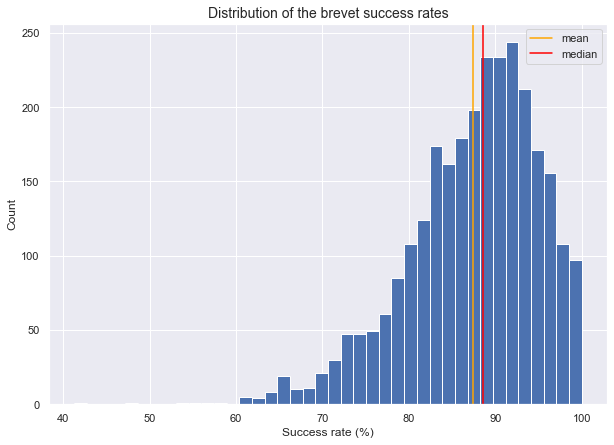

In [11]:
plt.figure(figsize=(10,7))
plt.hist(data_college.target, bins=40)
plt.axvline(x=data_college.target.mean(), color="orange", label='mean')
plt.axvline(x=data_college.target.quantile(.5), color="red", label='median')
plt.xlabel("Success rate (%)")
plt.ylabel("Count")
plt.title("Distribution of the brevet success rates", fontsize=14)
plt.legend(loc='best')
plt.show()

In [12]:
data_college.target.describe()

count    2804.000000
mean       87.397254
std         7.655491
min        41.300000
25%        82.900000
50%        88.550000
75%        93.000000
max       100.000000
Name: target, dtype: float64

In [13]:
print("The variance of the success rates in 2019 is %.2f" %data_college.target.std())

The variance of the success rates in 2019 is 7.66


## Naive merge with the city database

In order to integrate the socio-economic data available in our second database, it is possible to join the two databases at the city level, thanks to their unique code.

In [14]:
# merge on the city code
data_college = pd.merge(data_college, cities_data,
                        left_on='Commune et arrondissement code', right_on='insee_code', how='left')

# fill na by taking the average value at the departement level
city_col_with_na = []
for col in cities_data.columns:
    if cities_data[col].isna().sum() > 0:
        city_col_with_na.append(col)

#print(city_col_with_na)
for col in city_col_with_na:
    data_college[col] = data_college[['Département code', col]].groupby('Département code').transform(lambda x: x.fillna(x.mean()))
    
data_college.head()

Appartenance EP             Name  Coordonnée X  Coordonnée Y  \
0             HEP  amiral de rigny      912665.1     6845812.4   
1             HEP      jules verne      355005.1     6689619.8   
2             HEP     albert camus      637334.2     7068125.0   
3             HEP     jacques brel      861666.4     6473135.3   
4             HEP  jacques prevert      612683.8     7013615.0   

  Etablissement sensible  CATAEU2010  \
0                    NON       111.0   
1                    NON       111.0   
2                    NON       112.0   
3                    NON       221.0   
4                    NON       120.0   

  Situation relative à une zone rurale ou autre Commune code    City_name  \
0                                        urbain        54528         toul   
1                                        urbain        44109       nantes   
2                                 intermédiaire        62534      lumbres   
3                                 intermédiaire        38034  beaurepaire   
4                                 intermédiaire        80598      nouvion   

  Commune et arrondissement code Commune et arrondissement nom  \
0                          54528                          TOUL   
1                          44109                        NANTES   
2                          62534                       LUMBRES   
3                          38034                   BEAUREPAIRE   
4                          80598                       NOUVION   

  Département code     Département nom  Académie code Académie nom  \
0               54  MEURTHE-ET-MOSELLE           12.0   NANCY-METZ   
1               44    LOIRE-ATLANTIQUE           17.0       NANTES   
2               62       PAS-DE-CALAIS            9.0        LILLE   
3               38               ISERE            8.0     GRENOBLE   
4               80               SOMME           20.0       AMIENS   

   Région code          Région nom  Région 2016 code          Région 2016 nom  \
0           41            LORRAINE                44                GRAND-EST   
1           52    PAYS DE LA LOIRE                52         PAYS-DE-LA-LOIRE   
2           31  NORD-PAS-DE-CALAIS                32          HAUTS-DE-FRANCE   
3           82         RHONE-ALPES                84  AUVERGNE-ET-RHONE-ALPES   
4           22            PICARDIE                32          HAUTS-DE-FRANCE   

   Nb élèves  Nb 6èmes  Nb 5èmes  Nb 4èmes générales  Nb 3èmes générales  \
0      482.0     108.0     119.0               122.0               124.0   
1      404.0      77.0      95.0               113.0               119.0   
2      797.0     196.0     207.0               192.0               144.0   
3      606.0     170.0     139.0               155.0               142.0   
4      313.0      84.0      86.0                72.0                71.0   

   Nb 6ème SEGPA  Nb 5ème SEGPA  Nb 4ème SEGPA  Nb 3ème SEGPA  Nb SEGPA  \
0            0.0            0.0            0.0            0.0       0.0   
1            0.0            0.0            0.0            0.0       0.0   
2            6.0           16.0           10.0           15.0      47.0   
3            0.0            0.0            0.0            0.0       0.0   
4            0.0            0.0            0.0            0.0       0.0   

   Nb 3èmes générales retardataires  Nb divisions  \
0                              16.0          19.0   
1                              10.0          15.0   
2                              20.0          32.0   
3                              25.0          23.0   
4                               7.0          13.0   

   Nb 6èmes provenant d'une école EP  \
0                                0.0   
1                               84.0   
2                                0.0   
3                              122.0   
4                                0.0   

   Nb 5èmes 4èmes et 3èmes générales Latin ou Grec  \
0                                             16.0   
1                   

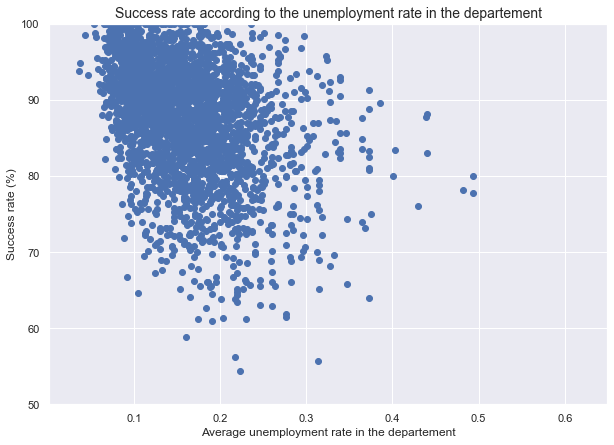

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(data_college['unemployment_rate'], data_college['target'])
plt.xlabel("Average unemployment rate in the departement")
plt.ylabel("Success rate (%)")
plt.title("Success rate according to the unemployment rate in the departement", fontsize=14)
plt.ylim(50,100)
plt.show()

At first glance, it would appear that the unemployment rate in the city has a negative effect on the exam pass rate. This supports the idea that socio-economic variables in the environment in which the school is located may be crucial explanatory factors.

## Geographic visualization

<div class="alert alert-block alert-danger">
<b>Important note:</b> In order to correctly see the different dynamic maps, please run this notebook making sure you have an internet connection (because it's dynamic). <br>
    An other solution to visualize the maps correctly, is to look at the compiled notebook <a href="https://nbviewer.jupyter.org/github/CedricAllainEnsae/success-rates-brevet/blob/master/Starting_kit_taux-de-succes-brevet.ipynb">here</a>.
</div>

Let's look at the distribution of the success rate by department.

In [16]:
# Create a dynamic map
def plot_per_department(column, data_college,
                        cmap='OrRd_r',
                        path_geo_data = './data/donnees_geographiques/fichiers_geopandas/'):
    '''
    Functions which returns an interactive map of France colored by department according
    to the value of the feature "column" (for example the target).
    
    Parameters:
        column (string): the name of the column to plot per department
        data_college: the data frame with the data per college
        path_geo_data: path to a geojson file of france
    '''
    
    dep_df = data_college.groupby('Département code').agg({column:'mean'}).reset_index()
    dep_df.columns = ['code', column] # we rename the department code because it's the key of the geojson file
    
    
    m = folium.Map(location=[46.45,1], zoom_start=6) #map centered on France

    # Add the chloropleth
    m.choropleth(
       geo_data=path_geo_data+'departements.geojson.txt', # geoJSON file or url to geojson
       name='choropleth',
       data=dep_df, # Pandas dataframe
       columns=['code',column], # key and value of interest from the dataframe
       key_on='feature.properties.code', # key to link the json file and the dataframe
       fill_color=cmap, # colormap
       fill_opacity=0.7,
       line_opacity=0.2,
       legend_name=column
    )
    
    display(m)
    
    return None

In [17]:
plot_per_department(column='target', data_college=data_college)

Now we can look in detail, at the city level.

Thanks to the function below, you can choose a department and display an interactive map of the *collèges*. You can click on the little little circles (each of them  corresponds to a *collège*) and see some information about it:
   - its name
   - its success rate
   - its city and department
   - Its 'Appartenance EP':
       - 'HEP' = it's not a priority education college
       - 'REP' : it is
       - 'REPPLUS' : the highest level of priority

In [18]:
# Create a dynamic map for the cities in each department
def plot_cities_in_dep(column, dep_code, dep_name,
                       data_college,
                       url_parent='https://france-geojson.gregoiredavid.fr/repo/departements/',
                       cmap='OrRd_r'):
    '''
    column (string): name of the column to plot
    dep_code(string): the code of the department to plot 
    dep_name (string): the name of the department
    data_college : the data frame with data per college
    url_parent : the url of France GEOJSON
    '''

    cities_df = data_college[data_college['Département code']==dep_code]
    cities_df_group = cities_df.groupby('Commune et arrondissement code').agg({column:'mean'}).reset_index()
    cities_df_group.columns = ['code', column]
    
    #url to geojson of the department
    url = url_parent+dep_code+'-'+dep_name+'/communes-'+dep_code+'-'+dep_name+'.geojson'
    coords = gpd.read_file(url).loc[0].geometry.centroid.coords[0] #coordinates where the maps is centered
    
    m = folium.Map(location=[coords[1],coords[0]], zoom_start=10) #map centered on France
    
    # Add the chloropleth
    m.choropleth(
       geo_data=url,# url to geojson of the department
       name='choropleth',
       data=cities_df_group, # Pandas dataframe
       columns=['code',column], # key and value of interest from the dataframe
       key_on='feature.properties.code', # key to link the json file and the dataframe
       fill_color=cmap, # colormap
       fill_opacity=0.7,
       line_opacity=0.2,
       legend_name=column
    )
    
    #add the colleges marker 
    for ix, row in cities_df.iterrows():
        # Create a popup tab with the college name and its success_rate
        popup_df = pd.DataFrame(data=[['College', row['Name']], 
                                      ['Sucess rate', str(row['target'])+'%'], 
                                      ['City', row['Commune et arrondissement nom']],
                                      ['Department', row['Département nom']],
                                      ['Appartenance EP', row['Appartenance EP']]])
        popup_html = popup_df.to_html(classes='table table-striped table-hover table-condensed table-responsive', index=False, header=False)
        # Create a marker on the map
        folium.CircleMarker(location = [row['Latitude'],row['Longitude']], radius=2, popup=folium.Popup(popup_html), color='red', alpha=0.5, fill_color='#0000FF').add_to(m)

    display(m)
    
    return None

In [19]:
plot_cities_in_dep(column='target',
                   dep_code='75',
                   dep_name='paris',
                   data_college=data_college)

- Without any surprise, some of the richest arrondissements like the $5^{th}$, the $7^{th}$or the $8^{th}$ have the highest average success rates (more than 94%)
- Surprisingly the $10^{th}$ arrondissement has an average success rate (76-80%) lower than the national average (87.4 %). This is because the *collège La Grange aux Belles* which is 'REP' has a very bad success rate of 67% and there are only 4 *collèges* in the arrondissement. One must be careful of the interpretation of those rates in some cities.

<a id='Macro_socio_economic_features'></a>

## Macro socio-economic features
Some of the following features' possible link with the target are worth investigating:
- the median standard of living
- the poverty rate
- the unemployment rate

### The median standard of living. 
- The national average is approximatively of 20 000 euros. In average, french cities have half of their households wich live with less than 20 000 euros per year

In [20]:
print('Mean median living wage: %.5f' %cities_data.med_std_living.mean())

Mean median living wage: 20633.28419


In [21]:
plot_per_department(column='med_std_living', data_college=data_college, cmap='Blues_r')

In [22]:
plot_cities_in_dep(column='med_std_living', dep_code='75', dep_name='paris',
                   data_college=data_college, cmap='Blues_r')

In [23]:
plot_cities_in_dep(column='med_std_living', dep_code='93', dep_name='seine-saint-denis',
                   data_college=data_college, cmap='Blues_r')

- As expected by clicking on somme *collèges* in the **darked blue zones** which correspond to cities where the **median standard of living is very low**, the sucess rates of *collèges* are not good. 
- Example, the *collège Jean Lurcat* in Saint Denis has a success rate of 72.7%

### The unemployment rate
- National average (per city) in 2015 : 11%

In [24]:
print('Average unemployment rate: %.2f%%' %(cities_data.unemployment_rate.mean()*100))

Average unemployment rate: 11.05%


In [25]:
plot_per_department(column='unemployment_rate', data_college=data_college, cmap='Purples')

In [26]:
plot_cities_in_dep(column='unemployment_rate', dep_code='75', dep_name='paris',
                   data_college=data_college, cmap='Purples')

- In the $19^{th}$ arrondissement, the unemployment rate is higher and the *collèges* have a success rate under the national average (87.3%)

### The poverty rate

- Definition : percentage of people who live with less than 60% of the median standard of living.
- National average per city : 13.9%

In [27]:
print('Average poverty rate: %.02f%%' %cities_data.poverty_rate.mean())

Average poverty rate: 13.85%


In [28]:
plot_per_department('poverty_rate', data_college, cmap='Greens')

In [29]:
plot_cities_in_dep('poverty_rate', dep_code='62', 
                   dep_name='pas-de-calais', data_college=data_college, cmap="Greens")

- For the department *Pas-de-Calais* where there are a lot of cities with a high poverty rate, it's not clear wether the poverty rate of the city has a clear impact on the success rate of a *collège*. 

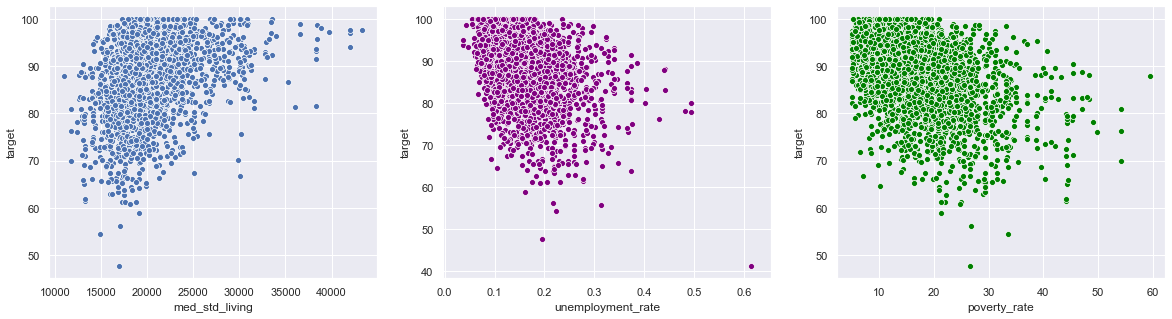

In [30]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.scatterplot(x='med_std_living', y='target', data=data_college, ax=ax[0])
sns.scatterplot(x='unemployment_rate', y='target', color='purple',
                data=data_college.dropna(subset=['unemployment_rate']), ax=ax[1])
sns.scatterplot(x='poverty_rate', y='target', color='green',
                data=data_college.dropna(subset=['poverty_rate']), ax=ax[2])
plt.show()

- The median standard of living and the poverty rate seem to be discriminant
- The influence of the unemployment rate is less clear

## Priority Education Network and "sensitive" schools

The priority education policy aims to reduce the gaps in achievement between pupils enrolled in priority education and those who are not. Two types of networks have been identified: the REP+, which concern neighbourhoods or isolated sectors with the greatest concentration of social difficulties that have a strong impact on educational success, and the more socially mixed REPs that are more socially mixed but encounter more significant social difficulties than those of *collèges* and schools outside priority education. Not every *collèges* are in the priority education network, and in this case they are labelled as "HEP" (outside the priority education network, *Hors éducation prioritaire*).

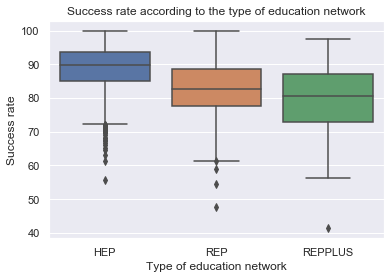

In [31]:
ax = sns.boxplot(x="Appartenance EP", y="target", data=data_college)
ax.axes.set_title("Success rate according to the type of education network")
ax.set_xlabel("Type of education network")
ax.set_ylabel("Success rate");

It can easily be observed that the success rate is significantly lower when the *collège* is part of a priority education network (this is all the more the case for the REP+ network). However, no causal link can be drawn from this, since *collèges* are placed in a priority education system precisely when they have a certain amount of ground to make up in relation to other *collèges*.

Allongside the priority education networks, there exists another label for *collège* in difficulties, the *établissements sensibles*.
The so-called "sensitive" schools are secondary schools in which a climate of insecurity prevails that seriously compromises pupils' schooling. They are not necessarily in priority education.

The development of violence in schools has led the Ministers of National Education and the Interior to strengthen their collaboration. The latter has led, since 1992, to the classification of certain public secondary schools as "sensitive" schools, without saying, however, that violence is present only in these schools.

Like REPs, sensitive establishments benefit from special measures. They are the subject of exceptional efforts in terms of innovative and adapted pedagogy, by strengthening the timetable potential (class splitting, tutoring, tutoring, directed studies, etc.) and by the allocation of additional jobs, by strengthening the presence of adults (increase in the number of senior educational advisers, boarding school teachers, day school supervisors, etc.) and by appointing two head teachers per class.

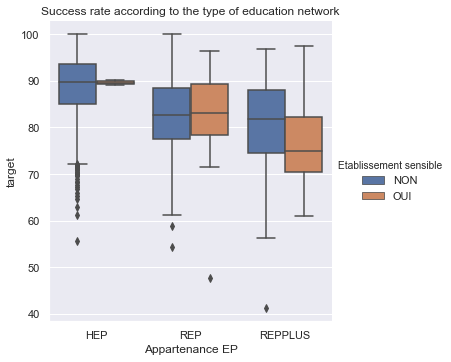

In [32]:
sns.catplot(x="Appartenance EP", y="target", hue="Etablissement sensible", kind="box", data=data_college)
plt.title('Success rate according to the type of education network');

## Analysis of class size

Another determinant of academic success is the number of students per class. It is easy to understand that a smaller class size makes it much easier for the teacher to spend more time with each student, thus ensuring that all students progress through the classroom without some being left behind. This is true at all levels of education but mainly during the first years of schooling.

Unfortunately, the variable "number of students" per class is not present in our database. However, it is possible to create a variable "average number of pupils per class" from the variables "total number of pupils in the school" and "number of classes".

In [33]:
data_college['average_class_size'] = data_college['Nb élèves'] / data_college['Nb divisions']

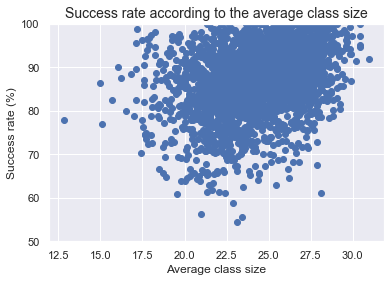

In [34]:
plt.scatter(data_college['average_class_size'], data_college['target'])
plt.xlabel("Average class size")
plt.ylabel("Success rate (%)")
plt.title("Success rate according to the average class size", fontsize=14)
plt.ylim(50,100)
plt.show()

In this case, the effect of class size on the exam pass rate cannot be determined directly because the rest of the variables must be controlled for. However, it is interesting to keep such a variable, given its importance in the literature.

In the same way, it is possible to create other new variables, such as the share of pupils who are in a general stream or the share of pupils who are in a European or international section.

In [35]:
# percentage of pupils in the general stream
data_college['percent_general_stream'] = data_college['Nb 6èmes 5èmes 4èmes et 3èmes générales'] / data_college['Nb élèves']
# percentage of pupils in an european or international section
data_college['percent_euro_int_section'] = data_college['Nb 6èmes 5èmes 4èmes et 3èmes générales sections européennes et internationales'] / data_college['Nb élèves']
# percentage of pupils doing Latin or Greek
sum_global_5_to_3 = data_college['Nb 5èmes'] + data_college['Nb 4èmes générales'] + data_college['Nb 3èmes générales']
data_college['percent_latin_greek'] = data_college['Nb 5èmes 4èmes et 3èmes générales Latin ou Grec'] / sum_global_5_to_3
# percentage of pupils that are in a SEGPA class
data_college['percent_segpa'] = data_college['Nb SEGPA'] / data_college['Nb élèves']

## Analysis of the quantitative features

In [36]:
quant_features = ['Nb élèves', 'Nb 3èmes générales', 'Nb 3èmes générales retardataires',
                  'Nb 5èmes 4èmes et 3èmes générales Latin ou Grec', 'Nb élèves pratiquant langue rare',
                  'Nb 3ème SEGPA',
                  'average_class_size', 'percent_general_stream', 'percent_euro_int_section']
data_college[quant_features].describe()

Nb élèves  Nb 3èmes générales  Nb 3èmes générales retardataires  \
count  2804.000000         2804.000000                       2804.000000   
mean    514.233951          119.249643                         18.199001   
std     161.653665           39.560515                         11.045183   
min     142.000000           28.000000                          0.000000   
25%     398.000000           91.000000                         11.000000   
50%     502.500000          116.000000                         16.000000   
75%     619.000000          143.000000                         23.000000   
max    1711.000000          419.000000                        211.000000   

       Nb 5èmes 4èmes et 3èmes générales Latin ou Grec  \
count                                      2804.000000   
mean                                         17.579173   
std                                          24.753493   
min                                           0.000000   
25%                                           0.000000   
50%                                          13.000000   
75%                                          25.000000   
max                                         211.000000   

       Nb élèves pratiquant langue rare  Nb 3ème SEGPA  average_class_size  \
count                       2804.000000    2804.000000         2804.000000   
mean                         492.041369       4.278531           24.424584   
std                          154.696597       7.475813            2.519258   
min                          139.000000       0.000000           12.866667   
25%                          379.000000       0.000000           22.666667   
50%                          478.000000       0.000000           24.666667   
75%                          595.000000       9.000000           26.364833   
max                         1698.000000      35.000000           30.937500   

       percent_general_stream  percent_euro_int_section  
count             2804.000000               2804.000000  
mean                 0.237757                  0.057011  
std                  0.033404                  0.022575  
min                  0.101480                  0.000000  
25%                  0.215622                  0.040882  
50%                  0.236968                  0.054618  
75%                  0.257533                  0.069660  
max                  0.560000                  0.175000

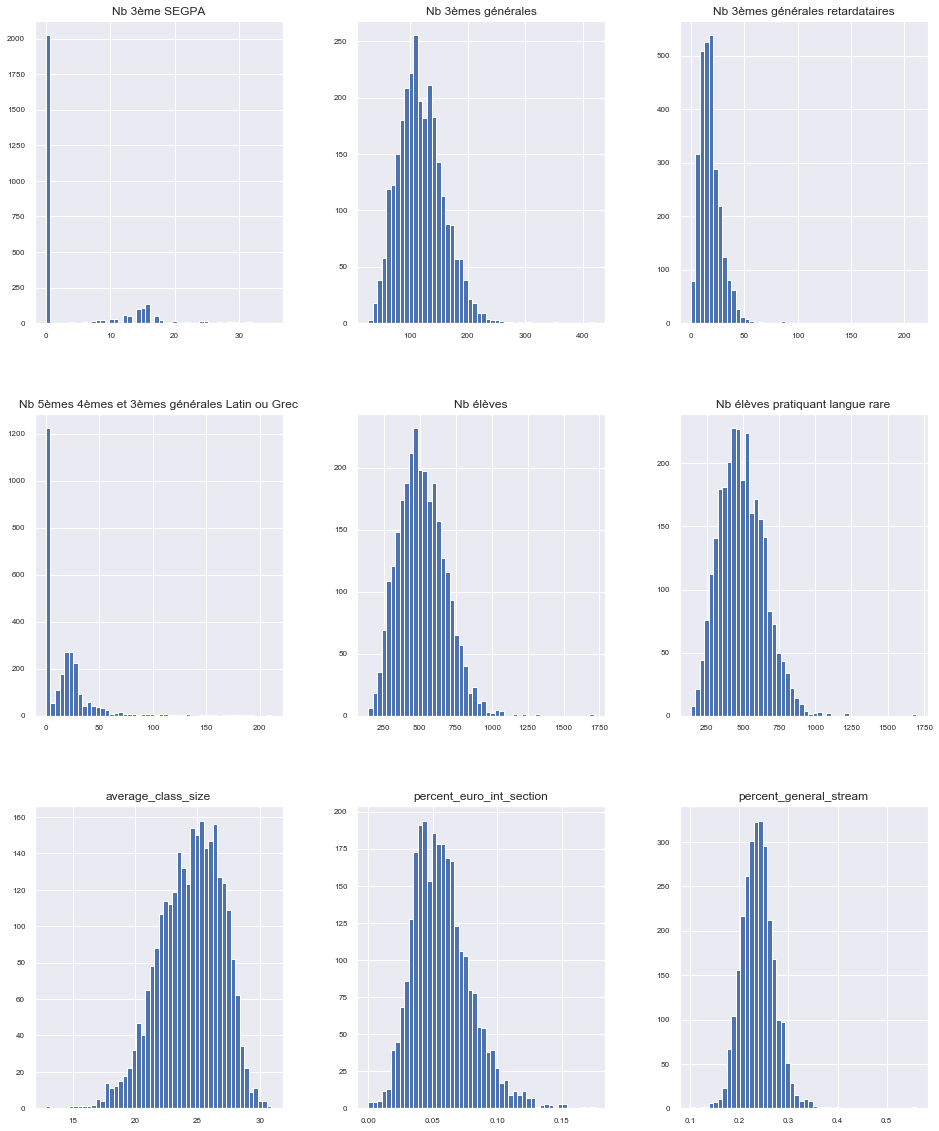

In [37]:
data_college[quant_features].hist(figsize=(16, 20), bins = 50, xlabelsize=8, ylabelsize=8)
plt.show()

We can observe that most of our quantitative features have a Gaussian distribution shape.

## Correlation study

Finally, we can have a look on the correlation between our different quantitative features and our target.

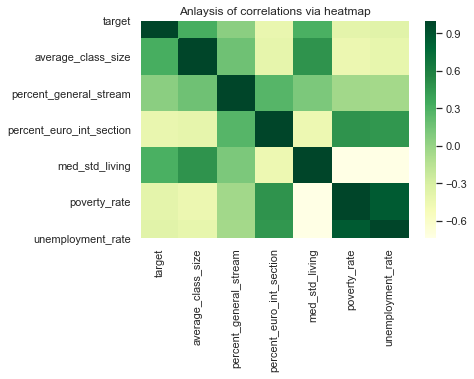

In [38]:
features_for_corr = ['target', 'average_class_size',
                     'percent_general_stream', 'percent_euro_int_section',
                     'med_std_living', 'poverty_rate', 'unemployment_rate']
sns.heatmap(data_college[features_for_corr].corr(), cmap='YlGn')
plt.title('Anlaysis of correlations via heatmap');

# Workflow

<div style="text-align: center">
<img src="img/workflow.png" width="900px">
</div>

The work flow is composed of two essential elements that make up the submission: the feature extractor and the regressor. The first allows both the preparation of initial data and the creation of new variables. The second, on the other hand, allows a supervised learning model to be trained so that the success rate on the exam can be correctly predicted. This model is trained on a part of the base obtained from the feature extractor output, then is evaluated on the remaining part.

We will use a Random Forest Regressor model in order to predict the different success rates.

In [39]:
data_college = pd.read_csv('./data/train.csv')
y_array = data_college['target'].values
X_df = data_college.drop('target', axis=1)

cities_data = pd.read_csv("./data/donnees_geographiques/cities_data_filtered.csv", index_col=0)
keep_col_cities = ['population', 'SUPERF', 'med_std_living', 'poverty_rate', 'unemployment_rate']

In [40]:
def process_students(X):
    """Create new features linked to the pupils"""
    # average class size
    X['average_class_size'] = X['Nb élèves'] / X['Nb divisions']
    # percentage of pupils in the general stream
    X['percent_general_stream'] = X['Nb 6èmes 5èmes 4èmes et 3èmes générales'] / X['Nb élèves']
    # percentage of pupils in an european or international section
    X['percent_euro_int_section'] = X['Nb 6èmes 5èmes 4èmes et 3èmes générales sections européennes et internationales'] / X['Nb élèves']
    # percentage of pupils doing Latin or Greek
    sum_global_5_to_3 = X['Nb 5èmes'] + X['Nb 4èmes générales'] + X['Nb 3èmes générales']
    X['percent_latin_greek'] = X['Nb 5èmes 4èmes et 3èmes générales Latin ou Grec'] / sum_global_5_to_3
    # percentage of pupils that are in a SEGPA class
    X['percent_segpa'] = X['Nb SEGPA'] / X['Nb élèves']

    return np.c_[X['average_class_size'].values,
                 X['percent_general_stream'].values,
                 X['percent_euro_int_section'].values,
                 X['percent_latin_greek'].values,
                 X['percent_segpa'].values]
        
        
def merge_naive(X):
    # merge the two databases at the city level
    df = pd.merge(X, cities_data,
                  left_on='Commune et arrondissement code', right_on='insee_code', how='left')

    # fill na by taking the average value at the departement level
    for col in keep_col_cities:
        if cities_data[col].isna().sum() > 0:
            df[col] = df[['Département code', col]].groupby('Département code').transform(lambda x: x.fillna(x.mean()))

    return df[keep_col_cities]

In [41]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Transformers
students_col = ['Nb élèves', 'Nb divisions', 'Nb 6èmes 5èmes 4èmes et 3èmes générales',
                'Nb 6èmes 5èmes 4èmes et 3èmes générales sections européennes et internationales',
                'Nb 5èmes', 'Nb 4èmes générales', 'Nb 3èmes générales',
                'Nb 5èmes 4èmes et 3èmes générales Latin ou Grec', 'Nb SEGPA']
students_transformer = FunctionTransformer(process_students, validate=False)

num_cols = ['Nb élèves', 'Nb 3èmes générales', 'Nb 3èmes générales retardataires',
            "Nb 6èmes provenant d'une école EP"]
numeric_transformer = Pipeline(steps=[('scale', StandardScaler())])

cat_cols = ['Appartenance EP', 'Etablissement sensible', 'CATAEU2010',
            'Situation relative à une zone rurale ou autre']
categorical_transformer = Pipeline(steps=[('encode', OneHotEncoder(handle_unknown='ignore'))])

merge_col = ['Commune et arrondissement code', 'Département code']
merge_transformer = FunctionTransformer(merge_naive, validate=False)

drop_cols = ['Name', 'Coordonnée X', 'Coordonnée Y', 'Commune code', 'City_name',
             'Commune et arrondissement code', 'Commune et arrondissement nom',
             'Département nom', 'Académie nom', 'Région nom', 'Région 2016 nom',
             'Longitude', 'Latitude', 'Position']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('students', make_pipeline(students_transformer, SimpleImputer(strategy='mean'), StandardScaler()), students_col),
        ('merge', make_pipeline(merge_transformer, SimpleImputer(strategy='mean')), merge_col),
        ('drop cols', 'drop', drop_cols),
        ], remainder='drop') # remainder='drop' or 'passthrough'

In [42]:
# check it works
preprocessor.fit_transform(X_df)

array([[-1.99436869e-01,  1.20099648e-01, -1.99126960e-01, ...,
         1.76900000e+04,  2.04640496e+01,  1.90428479e-01],
       [-6.82035964e-01, -6.31154308e-03, -7.42447099e-01, ...,
         2.12626667e+04,  1.62738751e+01,  1.69835458e-01],
       [ 1.74952101e+00,  6.25744414e-01,  1.63086466e-01, ...,
         1.70700000e+04,  2.01850294e+01,  1.65437694e-01],
       ...,
       [-2.17998373e-01, -2.08569449e-01, -5.61340386e-01, ...,
         2.52770000e+04,  1.58721359e+01,  7.67676768e-02],
       [ 6.42017962e-01,  1.95946363e-01, -1.08573604e-01, ...,
         2.43361538e+04,  7.18577122e+00,  7.75329013e-02],
       [-1.00995586e+00, -7.39496454e-01, -6.51893743e-01, ...,
         1.70622222e+04,  2.37536543e+01,  2.18798151e-01]])

In [43]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=5, max_depth=50, max_features=10)

In [44]:
from sklearn.metrics import make_scorer, mean_squared_error

def normalized_rmse(y_true, y_pred):
    """Normalized RMSE"""
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.std(y_true) 
    
custom_loss = make_scorer(normalized_rmse, greater_is_better=False)

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

clf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', regressor)])

cv = ShuffleSplit(n_splits=5, test_size=0.25)

scores_Xdf = -cross_val_score(clf, X_df, y_array, cv=cv, scoring=custom_loss)

print("mean: %.2e (+/- %.2e)" % (scores_Xdf.mean(), scores_Xdf.std()))

mean: 9.35e-01 (+/- 1.92e-02)


# Submission

To make a RAMP submission you will need to create a new directory within `submissions`, naming it as you wish, and a file named `estimator.py` within the new directory, e.g. `submissions/my_new_sub/estimator.py`

Within `estimator.py`, define a function named `get_estimator` that returns a scikit-learn pipeline or estimator that performs the desired feature extraction and regression.

For example, the `estimator.py` file below will perform the workflow detailed above:

In [46]:
import os

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


def _process_students(X):
    """Create new features linked to the pupils"""

    # average class size
    X['average_class_size'] = X['Nb élèves'] / X['Nb divisions']
    # percentage of pupils in the general stream
    X['percent_general_stream'] = X['Nb 6èmes 5èmes 4èmes et 3èmes générales'] / X['Nb élèves']
    # percentage of pupils in an european or international section
    X['percent_euro_int_section'] = X['Nb 6èmes 5èmes 4èmes et 3èmes générales sections européennes et internationales'] / X['Nb élèves']
    # percentage of pupils doing Latin or Greek
    sum_global_5_to_3 = X['Nb 5èmes'] + X['Nb 4èmes générales'] + X['Nb 3èmes générales']
    X['percent_latin_greek'] = X['Nb 5èmes 4èmes et 3èmes générales Latin ou Grec'] / sum_global_5_to_3
    # percentage of pupils that are in a SEGPA class
    X['percent_segpa'] = X['Nb SEGPA'] / X['Nb élèves']

    return np.c_[X['average_class_size'].values,
                    X['percent_general_stream'].values,
                    X['percent_euro_int_section'].values,
                    X['percent_latin_greek'].values,
                    X['percent_segpa'].values]

def _merge_naive(X):

    # read the database with the city information
    filepath = os.path.join(
        os.path.dirname(__file__), 'external_data.csv'
    )
    cities_data = pd.read_csv(filepath)
    # merge the two databases at the city level
    df = pd.merge(
        X, cities_data,left_on='Commune et arrondissement code',
        right_on='insee_code', how='left'
    )
    keep_col_cities = [
        'population',
        'SUPERF',
        'med_std_living',
        'poverty_rate',
        'unemployment_rate'
    ]
    # fill na by taking the average value at the departement level
    for col in keep_col_cities:
        if cities_data[col].isna().sum() > 0:
            df[col] = df[['Département code', col]].groupby('Département code').transform(lambda x: x.fillna(x.mean()))

    return df[keep_col_cities]

def get_estimator():

    students_col = [
        'Nb élèves', 'Nb divisions', 'Nb 6èmes 5èmes 4èmes et 3èmes générales',
        'Nb 6èmes 5èmes 4èmes et 3èmes générales sections européennes et internationales',
        'Nb 5èmes', 'Nb 4èmes générales', 'Nb 3èmes générales',
        'Nb 5èmes 4èmes et 3èmes générales Latin ou Grec', 'Nb SEGPA'
    ]
    num_cols = [
        'Nb élèves', 'Nb 3èmes générales', 'Nb 3èmes générales retardataires',
        "Nb 6èmes provenant d'une école EP"
    ]
    cat_cols = [
        'Appartenance EP', 'Etablissement sensible', 'CATAEU2010',
        'Situation relative à une zone rurale ou autre'
    ]
    merge_col = [
        'Commune et arrondissement code', 'Département code'
    ]
    drop_cols = [
        'Name', 'Coordonnée X', 'Coordonnée Y', 'Commune code', 'City_name',
        'Commune et arrondissement code', 'Commune et arrondissement nom',
        'Département nom', 'Académie nom', 'Région nom', 'Région 2016 nom',
        'Longitude', 'Latitude', 'Position'
    ]

    numeric_transformer = Pipeline(steps=[
        ('scale', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ])
    students_transformer = FunctionTransformer(
        _process_students, validate=False
    )
    students_transformer = make_pipeline(
                students_transformer, SimpleImputer(strategy='mean'),
                StandardScaler()
            )
    merge_transformer = FunctionTransformer(_merge_naive, validate=False)
    merge_transformer = make_pipeline(
        merge_transformer, SimpleImputer(strategy='mean')
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('students', students_transformer, students_col),
            ('merge', merge_transformer, merge_col),
            ('drop cols', 'drop', drop_cols),
        ], remainder='passthrough') # remainder='drop' or 'passthrough'

    regressor = RandomForestRegressor(
            n_estimators=5, max_depth=50, max_features=10
        )

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('classifier', regressor)
    ])

    return pipeline


## Submission

To test and submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#test-a-submission).

<div style="text-align: center">
<img src="img/diplome.png" width="300px">
</div>